<a href="https://colab.research.google.com/github/abhinavdwivedi1/Churn-modelling/blob/master/Abhinav_Dwivedi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. Read data from json files and csv files into a pandas data frame
2. Applying Pre-processing techniques like Tokenization, Stemming , Lemmatization etc. on data 
3. A brief analysis of the data like finding distribution of Departments and addressing the problem of class imbalance.
4. Developing a neural network model which consists of the following layers , A Word Embedding layer pre-trained on Glove and followed by a LSTM layer and dense layer.
5. Evaluating the trained model.


### Part I: Text Preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
import numpy
import os
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
import numpy as np
from gensim.models import word2vec
from sklearn import metrics
import pandas as pd
import time
from pandas.io.json import json_normalize
import json
from tqdm import tqdm

In [0]:
file_path = "drive/My Drive/data/docs/"

Data is loaded from different json files into a pandas data frame named df indexed by the Document Id and contains two Columns *Description* and *Department*

In [0]:
dataset = {}
labels = pd.read_csv("drive/My Drive/data/document_departments.csv")
df = pd.DataFrame()
for doc in tqdm(os.listdir(file_path)):
    #print(doc[0:7])
    path = os.path.join(file_path,doc)
    with open(path, 'r') as myfile:
        data=myfile.read()
    json_data = json.loads(data)
    #print(json_data['jd_information']['description'])
    department = labels.loc[labels['Document ID'] == int(doc[0:7])]['Department'].iloc[0]
    df = df.append(pd.DataFrame([[json_data['jd_information']['description'],department]], columns = ['Description','Department'], index = [doc[0:7]]))
    #jd_information = json_normalize(data=df)
    #dataset[doc] = df

100%|██████████| 1162/1162 [06:46<00:00,  2.75it/s]


In [0]:
df.head()

,Description,Department
7889799,"Greeting to all,dear applicant, we are hiring ...",Operations
7891497,URGENTLY REQUIRE A ''HOUSE DRIVER'' FOR ''K.S....,Ticketing
7889935,We are urgently looking for suitable candidate...,Ticketing
7894969,The following is the JD regarding the same.&nb...,Ticketing
7888001,Designation: Sr.Account&nbsp;Executive (ONLY F...,Finance


If you observe here there are so many fields of Description which are empty i.e the value of description field in jd_information is empty. 

In [0]:
df.loc[df['Description'] == ""]

,Description,Department
7899490,,Ticketing
7899494,,Ticketing
7899488,,Ticketing
7899500,,Ticketing
7913474,,Ticketing
7913472,,Ticketing
7913470,,Finance
7913466,,Ticketing
7913480,,Sales
7922962,,Ticketing


So here we are gonna to remove those fields

In [0]:
df = df[df.Description != '']

In [0]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 7889799 to 7889695
Data columns (total 2 columns):
Description    745 non-null object
Department     745 non-null object
dtypes: object(2)
memory usage: 17.5+ KB
None


## Data Pre-Processing

So here we have performed of the NLP pre-processing steps on our text. 

### Decontraction Mapping for the words

In [0]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
v = df.apply(lambda row: decontracted(row['Description']), axis=1)

In [0]:
df['Description'] = v

In [0]:
df.head(5)

,Description,Department
7889799,"Greeting to all,dear applicant, we are hiring ...",Operations
7891497,URGENTLY REQUIRE A ''HOUSE DRIVER'' FOR ''K.S....,Ticketing
7889935,We are urgently looking for suitable candidate...,Ticketing
7894969,The following is the JD regarding the same.&nb...,Ticketing
7888001,Designation: Sr.Account&nbsp;Executive (ONLY F...,Finance


### Cleaning the text- Punctuation Cleaner

In [0]:
import string
punctuations=string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
df['Description']=df['Description'].apply(lambda x:remove_punct(x))
df.head(10)

,Description,Department
7889799,Greeting to alldear applicant we are hiring fo...,Operations
7891497,URGENTLY REQUIRE A HOUSE DRIVER FOR KSA KINGDO...,Ticketing
7889935,We are urgently looking for suitable candidate...,Ticketing
7894969,The following is the JD regarding the samenbsp...,Ticketing
7888001,Designation SrAccountnbspExecutive ONLY FOR MA...,Finance
7889693,Dear CandidatesGreetings We are hiring for the...,Sales
7889431,hello candidateswe have a Mega drive for inter...,Customer service
7889689,Dear CandidatesGreetings nbspWe are hiring for...,Sales
7895011,Brief job profilenbspbull Develop content for ...,Content
7903427,Location Panjim Vapi Pune Girgaon Opera HouseS...,Ticketing


### Tokenization

In [0]:
import nltk

In [0]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
df['tokenized_description']=df.apply(lambda row:nltk.word_tokenize(row['Description']),axis=1 )

In [0]:
df.head()

,Description,Department,tokenized_description
7889799,Greeting to alldear applicant we are hiring fo...,Operations,"[Greeting, to, alldear, applicant, we, are, hi..."
7891497,URGENTLY REQUIRE A HOUSE DRIVER FOR KSA KINGDO...,Ticketing,"[URGENTLY, REQUIRE, A, HOUSE, DRIVER, FOR, KSA..."
7889935,We are urgently looking for suitable candidate...,Ticketing,"[We, are, urgently, looking, for, suitable, ca..."
7894969,The following is the JD regarding the samenbsp...,Ticketing,"[The, following, is, the, JD, regarding, the, ..."
7888001,Designation SrAccountnbspExecutive ONLY FOR MA...,Finance,"[Designation, SrAccountnbspExecutive, ONLY, FO..."


### Removing Stop Words

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

In [0]:

df['tokenized_description']=df['tokenized_description'].apply(lambda x: remove_stopwords(x))

In [0]:
df.head()

,Description,Department,tokenized_description
7889799,Greeting to alldear applicant we are hiring fo...,Operations,"[Greeting, alldear, applicant, hiring, bussine..."
7891497,URGENTLY REQUIRE A HOUSE DRIVER FOR KSA KINGDO...,Ticketing,"[URGENTLY, REQUIRE, A, HOUSE, DRIVER, FOR, KSA..."
7889935,We are urgently looking for suitable candidate...,Ticketing,"[We, urgently, looking, suitable, candidates, ..."
7894969,The following is the JD regarding the samenbsp...,Ticketing,"[The, following, JD, regarding, samenbspnbspSe..."
7888001,Designation SrAccountnbspExecutive ONLY FOR MA...,Finance,"[Designation, SrAccountnbspExecutive, ONLY, FO..."


### Stemming

In [0]:
ps = nltk.PorterStemmer()
def text_stemmer(text):
    text = [ps.stem(word) for word in text]
    return text

In [0]:
df['tokenized_description']=df['tokenized_description'].apply(lambda x: text_stemmer(x))

In [0]:
df.head()

,Description,Department,tokenized_description
7889799,Greeting to alldear applicant we are hiring fo...,Operations,"[greet, alldear, applic, hire, bussi, develop,..."
7891497,URGENTLY REQUIRE A HOUSE DRIVER FOR KSA KINGDO...,Ticketing,"[urgent, requir, A, hous, driver, for, ksa, ki..."
7889935,We are urgently looking for suitable candidate...,Ticketing,"[We, urgent, look, suitabl, candid, profil, tr..."
7894969,The following is the JD regarding the samenbsp...,Ticketing,"[the, follow, JD, regard, samenbspnbspsector, ..."
7888001,Designation SrAccountnbspExecutive ONLY FOR MA...,Finance,"[design, sraccountnbspexecut, onli, for, male,..."


### Lemmetizing

In [0]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk import WordNetLemmatizer,pos_tag
wn1=WordNetLemmatizer()
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def text_lemmatizer(text):
    return [wn1.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(text)]

In [0]:
df['tokenized_description']=df['tokenized_description'].apply(lambda x: text_lemmatizer(x))

In [0]:
df.head()

,Description,Department,tokenized_description
7889799,Greeting to alldear applicant we are hiring fo...,Operations,"[greet, alldear, applic, hire, bussi, develop,..."
7891497,URGENTLY REQUIRE A HOUSE DRIVER FOR KSA KINGDO...,Ticketing,"[urgent, requir, a, hous, driver, for, ksa, ki..."
7889935,We are urgently looking for suitable candidate...,Ticketing,"[we, urgent, look, suitabl, candid, profil, tr..."
7894969,The following is the JD regarding the samenbsp...,Ticketing,"[the, follow, jd, regard, samenbspnbspsector, ..."
7888001,Designation SrAccountnbspExecutive ONLY FOR MA...,Finance,"[design, sraccountnbspexecut, onli, for, male,..."


##Exploratory Data Analysis


Here we have found the distributions of Departments in our data

In [0]:
 import seaborn as sns

In [0]:
def category_counter(column):
    y=df[column].value_counts()
    x=set(df[column].values)
    print(y)

Ticketing                          230
Sales                              148
Digital Marketing                  132
Customer service                    49
Marketing                           30
Finance                             26
Operations                          25
Back office ticketing               16
Administration                      15
IT                                  13
Technology                          10
Presales                            10
Maintenance                          8
Public Relations                     5
Recruitment                          5
Engineering Design Construction      4
Logistics                            3
Marine Engineering                   3
Analytics                            2
Marine Deck                          2
Content                              2
Data entry                           2
Learning and Development             1
Marine Service Steward               1
Flight Operations                    1
Airline Ground Operations

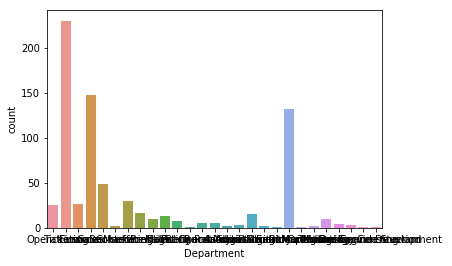

In [0]:
category_counter('Department')
sns.countplot(x="Department", data=df)

So here if you observe there is a serious problem of class imbalance. So we have used SMOTE to increase the dataset and for that evrey department should have atleast two samples. So for the classes having single sample we have duplicated them in the folllowing cells. 

In [0]:
df = df.append(df.loc[df['Department'] == "Marine Service Steward "])
df = df.append(df.loc[df['Department'] == "Learning and Development "])
df = df.append(df.loc[df['Department'] == "Flight Operations"])
df = df.append(df.loc[df['Department'] == "Procurement"])
df = df.append(df.loc[df['Department'] == "Airline Ground Operations"])

Ticketing                          230
Sales                              148
Digital Marketing                  132
Customer service                    49
Marketing                           30
Finance                             26
Operations                          25
Back office ticketing               16
Administration                      15
IT                                  13
Presales                            10
Technology                          10
Maintenance                          8
Recruitment                          5
Public Relations                     5
Engineering Design Construction      4
Marine Engineering                   3
Logistics                            3
Learning and Development             2
Procurement                          2
Marine Service Steward               2
Marine Deck                          2
Flight Operations                    2
Airline Ground Operations            2
Content                              2
Data entry               

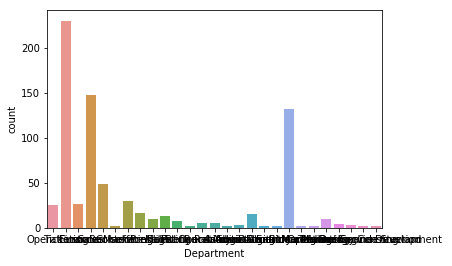

In [0]:
category_counter('Department')
sns.countplot(x="Department", data=df)

## Modelling and Evaluation

### Label Encoding the column 'Department'

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
le=LabelEncoder()
df['Department']=le.fit_transform(df['Department'])

In [0]:
df['Department'].head()

7889799    19
7891497    26
7889935    26
7894969    26
7888001     9
Name: Department, dtype: int64

Here , I have developed a keras model to classify the text. The following are the layers that i have developed.

1. Word Embedding Layer
2. LSTM Layer 
3. Dense Layer



The next following few cells contains processing of data , so that it fits in the Embedding Layer.

So Here we convert our words in the text into integers using Tokenizer class and stored in X_data variable. 

In [0]:

tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.tokenized_description)
X_data=tokenizer.texts_to_sequences(df.tokenized_description)

Here we have counted unique words in our whole text data.

In [0]:
word_index = tokenizer.word_index
print(type(word_index))
print('Total %s unique tokens.' % len(word_index))

<class 'dict'>
Total 7157 unique tokens.


Next we have taken glove GloVe word embedding file into memory as a dictionary of word to embedding array

embed_size is the size of the dense vector in the wor to vec conversion.


In [0]:
embed_size=50
input_length=100

In [0]:
embeddings_index = {}
f = open('drive/My Drive/data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


An embedding matrix is generated where each word in our text file is mapped to a dense vector. The number of absent words of our text in Glove is also printed.

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 5341 which is 74.63 % of total words


### Model Layers

In [0]:
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras import utils
from imblearn.over_sampling import SMOTE
from keras.layers import Input , Dense , LSTM,GlobalAveragePooling1D,GlobalMaxPooling1D,Bidirectional,LSTM,Conv1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Input Sequences to the Embedding Layer will be of different length and Keras prefers them to be of same length.

max_senten_length is that length of maximum words in an input sequence. and all input sequences are padded to have that length.



In [0]:
max_features=200000
max_senten_len=75
max_senten_num=4
embed_size=50

Word Embedding Layer in Keras

In [0]:

embedding_layer = Embedding(len(word_index)+1,
                            embed_size,
                            input_length=max_senten_len,
                            trainable=False)

Padding is done to our description data in the following cell so that input sequence have same length

In [0]:

X = list(sequence.pad_sequences(X_data, maxlen=max_senten_len))

In [0]:

print(len(X))
X=np.array(X)
print(X.shape)
Y=utils.np_utils.to_categorical(df.Department)
print(Y.shape)
print(Y[0])

750
(750, 75)
(750, 27)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0.]


As there is a problem of class imbalance SMOTE from imblearn is used to balnce the datasets among classes.

In [0]:
sm = SMOTE(random_state=42,k_neighbors=1)
X_res, Y_res = sm.fit_resample(X, Y)

Shuffling and Splitting the data into train and test data

In [0]:
X,Y = shuffle(X,Y)
X_train,X_test,Y_train,Y_test=train_test_split(X_res,Y_res,test_size=0.25)

Modelling our layers of our keras model

In [0]:
def classifier():
    inp = Input(shape=(max_senten_len,), dtype='int32')
    x = embedding_layer(inp)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))(x)
    outp = Dense(27, activation="softmax")(x)
    BiLSTM = Model(inp, outp)
    BiLSTM.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
    print(BiLSTM.summary())
    return BiLSTM

**Model Summary** 

In [0]:
model1=classifier()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 50)            357900    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_1 (Dense)              (None, 27)                6939      
Total params: 548,135
Trainable params: 190,235
Non-trainable params: 357,900
_________________________________________________________________
None


In [0]:
histo=model1.fit(X_train,Y_train,batch_size=32,epochs=100,validation_data=[X_test,Y_test])

Instructions for updating:
Use tf.cast instead.
Train on 4657 samples, validate on 1553 samples
Epoch 1/100
4657/4657 [==============================] - 47s 10ms/step - loss: 3.2954 - acc: 0.0382 - val_loss: 3.2952 - val_acc: 0.0206
Epoch 2/100
4657/4657 [==============================] - 44s 9ms/step - loss: 3.2948 - acc: 0.0588 - val_loss: 3.2950 - val_acc: 0.0245
Epoch 3/100
4657/4657 [==============================] - 44s 10ms/step - loss: 3.2940 - acc: 0.0462 - val_loss: 3.2949 - val_acc: 0.0592
Epoch 4/100
4657/4657 [==============================] - 45s 10ms/step - loss: 3.2934 - acc: 0.0726 - val_loss: 3.2947 - val_acc: 0.0625
Epoch 5/100
4657/4657 [==============================] - 44s 9ms/step - loss: 3.2926 - acc: 0.0769 - val_loss: 3.2945 - val_acc: 0.0586
Epoch 6/100
4657/4657 [==============================] - 45s 10ms/step - loss: 3.2920 - acc: 0.0721 - val_loss: 3.2942 - val_acc: 0.0586
Epoch 7/100
4657/4657 [==============================] - 44s 9ms/step - loss: 3.2913

In [0]:
score = model1.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

**RESULTS SUMMARY**

Accuracy on Test Data : 66.32%